# Import necessary libraries

In [4]:
import torch

# Check if CUDA (GPU support) is available
from pytorch_tabnet.tab_model import TabNetRegressor

# Set the device name based on CUDA availability
model = TabNetRegressor(device_name='cuda')  # Use 'cuda' if you have a GPU and CUDA set up


# model = TabNetRegressor().to(device)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)

import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 

import os
import wget
from pathlib import Path

# Load necessary data set

In [5]:
data_one = pd.read_csv("data/raw_data/jan2015toDec2016.csv")
data_two = pd.read_csv("data/raw_data/jan2017upwards.csv")

data_one = data_one.drop(columns=["block", "street_name"])
data_two = data_two.drop(columns=["block", "street_name"])

combined_data = pd.concat([data_one, data_two], ignore_index=True)

sorted_combined_data = combined_data.sort_values(by='month', ascending=True)

sorted_combined_data['remaining_lease'] = sorted_combined_data['remaining_lease'].fillna('NULL')

sorted_combined_data

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,07 TO 09,60.0,Improved,1986,70,255000.0
837,2015-01,SEMBAWANG,4 ROOM,01 TO 03,86.0,Model A2,2001,85,343000.0
836,2015-01,SEMBAWANG,4 ROOM,07 TO 09,90.0,Model A,2000,84,340000.0
835,2015-01,SEMBAWANG,4 ROOM,04 TO 06,90.0,Model A,2004,88,339000.0
834,2015-01,QUEENSTOWN,5 ROOM,19 TO 21,117.0,Improved,2012,96,950000.0
...,...,...,...,...,...,...,...,...,...
211434,2024-03,HOUGANG,4 ROOM,01 TO 03,105.0,Model A,1990,65 years 02 months,538888.0
211435,2024-03,HOUGANG,4 ROOM,10 TO 12,91.0,New Generation,1985,60 years 05 months,538000.0
211436,2024-03,HOUGANG,4 ROOM,07 TO 09,98.0,New Generation,1978,53 years 03 months,538000.0
211422,2024-03,HOUGANG,4 ROOM,04 TO 06,92.0,Model A,2019,94 years 07 months,573000.0


# Taking out useful CPI values

In [6]:
CPIData = pd.read_csv('data/raw_data/CPID.csv', header=None)
datetoextract = CPIData.iloc[0] 
indextoextract = CPIData.iloc[67]
data = {'Period': datetoextract, 'CPIvalue': indextoextract}

AccomsCPI = pd.DataFrame(data)

# Extract 'Year' and 'Month' and form the 'Date' column
AccomsCPI[['Year', 'Month']] = AccomsCPI['Period'].str.extract('(\d{4})(\w{3})', expand=True)  
AccomsCPI['Date'] = pd.to_datetime(AccomsCPI['Year'] + AccomsCPI['Month'], format='%Y%b')

# Filter by date and handle missing data
AccomsCPI = AccomsCPI[AccomsCPI['Date'] >= '2015-01-01']
AccomsCPI.loc[AccomsCPI['CPIvalue'] == 'na', 'CPIvalue'] = None  

# Convert 'CPIvalue' to float and 'Period' to the appropriate DateTime format
AccomsCPI['CPIvalue'] = AccomsCPI['CPIvalue'].astype(float)
AccomsCPI['Period'] = pd.to_datetime(AccomsCPI['Period'], format='%Y%b').dt.to_period('M')

# Info and final adjustments
AccomsCPI = AccomsCPI[['Period', 'CPIvalue']]  # Reorder and select necessary columns
AccomsCPI = AccomsCPI.reset_index(drop=True)

AccomsCPI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype    
---  ------    --------------  -----    
 0   Period    109 non-null    period[M]
 1   CPIvalue  109 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 1.8 KB


# Creating CPI adjustment values for selected period

In [7]:
AccomsCPI['AdjustmentValue'] = 1.0

# Loop to calculate AdjustmentValue
for idx in AccomsCPI.index:
    if idx != 0: 
        prev_adjustment_value = AccomsCPI.at[idx - 1, 'AdjustmentValue']
        prev_cpi_value = AccomsCPI.at[idx - 1, 'CPIvalue'] / 100
        AccomsCPI.at[idx, 'AdjustmentValue'] = prev_adjustment_value * (1 + prev_cpi_value)

# Converting Period to string
AccomsCPI['Period'] = AccomsCPI['Period'].astype(str)

# Printing the DataFrame to check the results
AccomsCPI.head(20)

,Period,CPIvalue,AdjustmentValue
0,2024-01,-2.7,1.000000
1,2023-09,0.3,0.973000
2,2023-10,-1.4,0.975919
3,2023-11,1.9,0.962256
4,2023-05,2.9,0.980539
5,2023-03,0.4,1.008975
6,2023-06,0.3,1.013011
7,2023-07,-1.0,1.016050
8,2023-01,-0.8,1.005889
9,2023-02,1.6,0.997842


# Visualising how price has changed since 2015

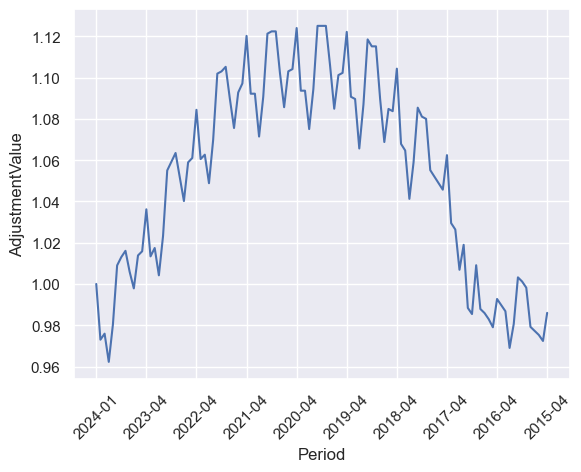

In [8]:
ax = sb.lineplot(data=AccomsCPI, x='Period', y='AdjustmentValue' )
ax.set_xticks(range(0, len(AccomsCPI), 12))  
ax.set_xticklabels([AccomsCPI['Period'][i] for i in range(0, len(AccomsCPI), 12)], rotation=45) 

plt.show()

# Adjusting resale price to current value 

In [9]:
merged_data = pd.merge(sorted_combined_data, AccomsCPI, left_on='month', right_on='Period', how='left')

# Fill missing AdjustmentValue with 1.0
merged_data['AdjustmentValue'] = merged_data['AdjustmentValue'].fillna(1.0)

# Adjust the sale price to today's cost
merged_data['resale_price_adjusted'] = merged_data['resale_price'] * merged_data['AdjustmentValue']

# Drop the unnecessary columns after adjustment
columns_to_drop = ['Period', 'CPIvalue']
merged_data.drop(columns=[col for col in columns_to_drop if col in merged_data.columns], axis=1, inplace=True)

#changing "x" years and "y" months into x+(y/12) years ---> eg 4years 6 months = 4.5years 
merged_data['years'] = merged_data['remaining_lease'].str.extract(r'(\d+) years').astype(float)
merged_data['months'] = merged_data['remaining_lease'].str.extract(r'(\d+) months').astype(float)
merged_data['remaining_lease'] = merged_data['years'] + merged_data['months'] / 12
merged_data = merged_data.drop(['years', 'months'], axis=1)

#changing 7 to 9 floor into average of 8th floor
merged_data['lower_storey'] = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float).iloc[:,0]
merged_data['upper_storey'] = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float).iloc[:,1]
merged_data['average_storey'] = (merged_data['lower_storey'] + merged_data['upper_storey']) / 2
columns_to_drop_final = ['lower_storey', 'upper_storey', 'storey_range', 'resale_price', 'AdjustmentValue', 'remaining_lease', 'month']
merged_data = merged_data.drop(columns=[col for col in columns_to_drop_final if col in merged_data.columns], axis=1)

merged_data.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212148 entries, 0 to 212147
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   town                   212148 non-null  object 
 1   flat_type              212148 non-null  object 
 2   floor_area_sqm         212148 non-null  float64
 3   flat_model             212148 non-null  object 
 4   lease_commence_date    212148 non-null  int64  
 5   resale_price_adjusted  212148 non-null  float64
 6   average_storey         212148 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 11.3+ MB


In [10]:
merged_data

,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price_adjusted,average_storey
0,ANG MO KIO,3 ROOM,60.0,Improved,1986,249701.035010,8.0
1,SEMBAWANG,4 ROOM,86.0,Model A2,2001,335872.372582,2.0
2,SEMBAWANG,4 ROOM,90.0,Model A,2000,332934.713346,8.0
3,SEMBAWANG,4 ROOM,90.0,Model A,2004,331955.493601,5.0
4,QUEENSTOWN,5 ROOM,117.0,Improved,2012,930258.757879,20.0
...,...,...,...,...,...,...,...
212143,HOUGANG,4 ROOM,105.0,Model A,1990,538888.000000,2.0
212144,HOUGANG,4 ROOM,91.0,New Generation,1985,538000.000000,11.0
212145,HOUGANG,4 ROOM,98.0,New Generation,1978,538000.000000,8.0
212146,HOUGANG,4 ROOM,92.0,Model A,2019,573000.000000,5.0


# See how different categorical data influence resale price (adjusted)

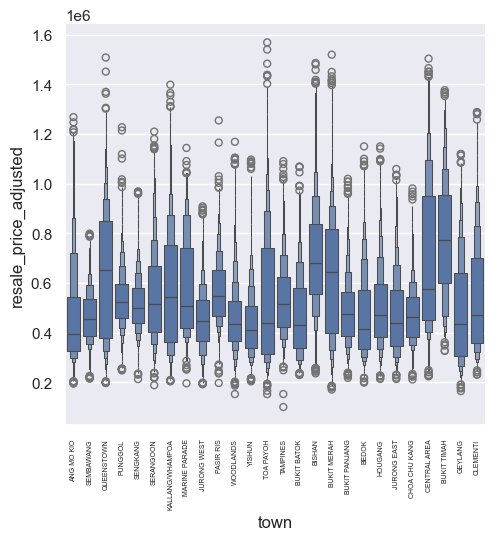

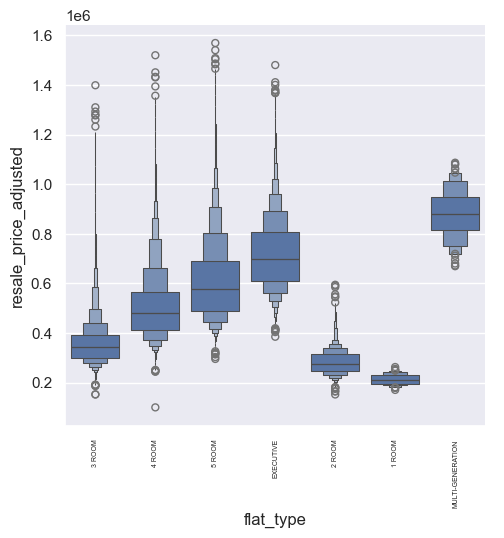

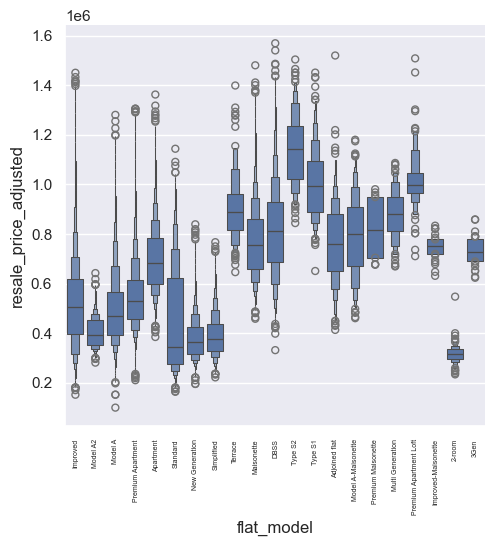

In [11]:
categoricaldata = pd.DataFrame(merged_data[['town', 'flat_type', 'flat_model', 'resale_price_adjusted']])
for var in ['town', 'flat_type', 'flat_model']:
    plot = sb.catplot(data=categoricaldata, x=var, y='resale_price_adjusted', kind = 'boxen')
    plot.set_xticklabels(fontsize=5,rotation = 90)  


# Encode categorical data from 0 to n-1 based on increasing resale price median 
# Plot heat map to visalise which factors has stronger correlation with resale price 

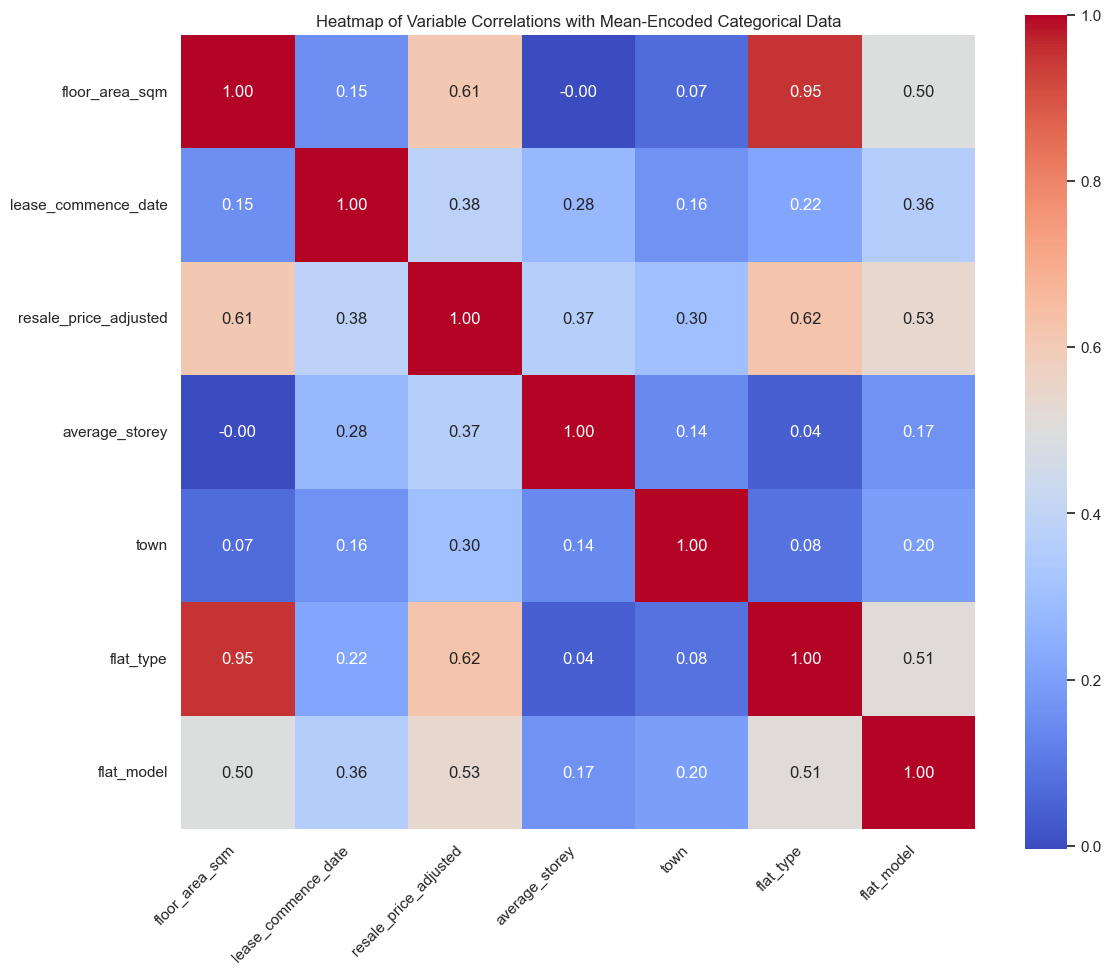

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

encoding_mappings = {}

# Assuming 'merged_data' is your DataFrame
# Let's separate the numerical and categorical columns
numerical_data = merged_data.select_dtypes(include=['float64', 'int64'])
categorical_columns = merged_data.select_dtypes(include=['object']).columns.tolist()

# Calculate the mean resale_price_adjusted for each category within the categorical variables and replace the categorical variable
encoded_data = merged_data.copy()
for column in categorical_columns:

    mean_prices = merged_data.groupby(column)['resale_price_adjusted'].median().sort_values()
    rank = {category: rank for rank, category in enumerate(mean_prices.index, 0)}
    
    encoding_mappings[column] = rank
    encoded_data[column] = merged_data[column].map(rank)


# Combine the numerical data with the mean-encoded categorical data
final_data = pd.concat([numerical_data, encoded_data[categorical_columns]], axis=1)

# Calculate the correlation matrix for the combined dataset
correlation_matrix = final_data.corr()

# Plot the heatmap matrix with annotations
plt.figure(figsize=(12, 10))  # Adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Heatmap of Variable Correlations with Mean-Encoded Categorical Data')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for better readability
plt.tight_layout()  # Adjust the layout so everything fits without overlap
plt.show()

# Visualising encoded categorical data

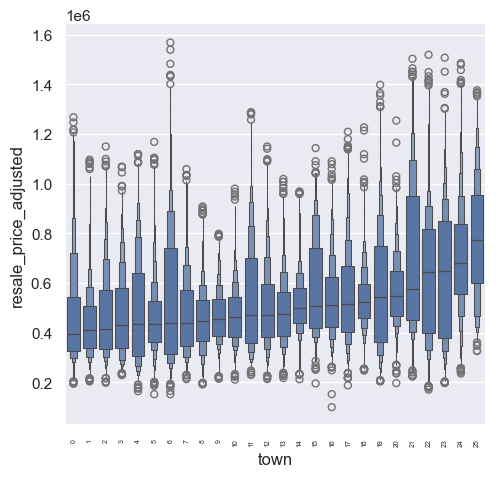

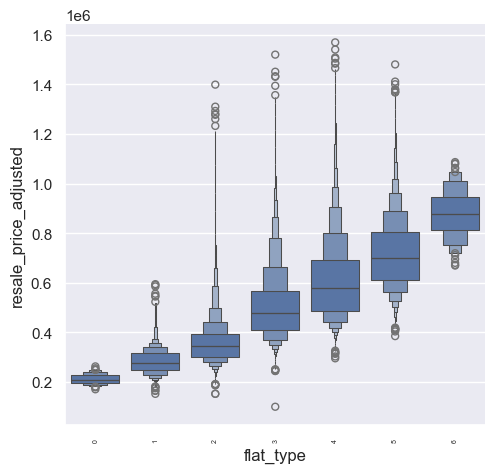

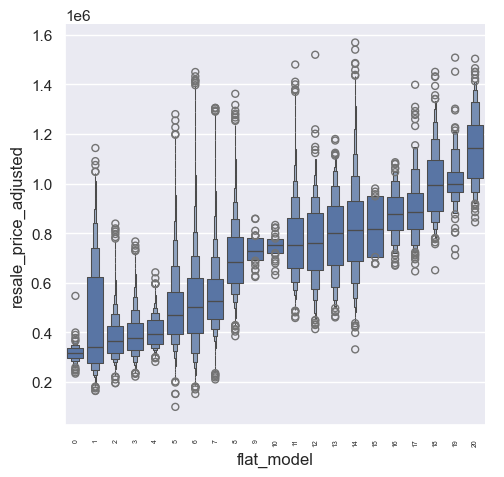

In [13]:
categoricaldata = pd.DataFrame(final_data[['town', 'flat_type', 'flat_model', 'resale_price_adjusted']])
for var in ['town', 'flat_type', 'flat_model']:
    plot = sb.catplot(data=categoricaldata, x=var, y='resale_price_adjusted', kind = 'boxen')
    plot.set_xticklabels(fontsize=5,rotation = 90)  


In [14]:
categoricaldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212148 entries, 0 to 212147
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   town                   212148 non-null  int64  
 1   flat_type              212148 non-null  int64  
 2   flat_model             212148 non-null  int64  
 3   resale_price_adjusted  212148 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 6.5 MB


In [15]:
def encode_new_input(new_input, encoding_mappings):
# If new_input is a dictionary, convert it to a DataFrame
    if isinstance(new_input, dict):
        new_input = pd.DataFrame([new_input])
    
    # If new_input is a list of dictionaries, convert it to a DataFrame
    elif isinstance(new_input, list):
        new_input = pd.DataFrame(new_input)

    # Ensure that new_input is a DataFrame at this point
    if not isinstance(new_input, pd.DataFrame):
        raise ValueError("new_input must be a pandas DataFrame, a dictionary, or a list of dictionaries.")    
    new_input_encoded = new_input.copy()
    for column, mapping in encoding_mappings.items():
        if column in new_input.columns:
            # Apply the mapping to the column
            new_input_encoded[column] = new_input[column].map(mapping)
            # Fill in NaN values if the category was not seen during training
            if new_input_encoded[column].isna().any():
                unknown_rank = np.median(list(mapping.values()))
                # Use direct assignment instead of inplace=True
                new_input_encoded[column] = new_input_encoded[column].fillna(unknown_rank)
    
    return new_input_encoded

# Employing basic linearing regression model with the numerical data

In [16]:
final_data.head()

,floor_area_sqm,lease_commence_date,resale_price_adjusted,average_storey,town,flat_type,flat_model
0,60.0,1986,249701.035010,8.0,0,2,6
1,86.0,2001,335872.372582,2.0,9,3,4
2,90.0,2000,332934.713346,8.0,9,3,5
3,90.0,2004,331955.493601,5.0,9,3,5
4,117.0,2012,930258.757879,20.0,23,4,6


floor_area_sqm           0.267109
lease_commence_date      0.132050
resale_price_adjusted    1.013401
average_storey           1.623230
town                     0.105263
flat_type                0.212238
flat_model               1.312911
dtype: float64


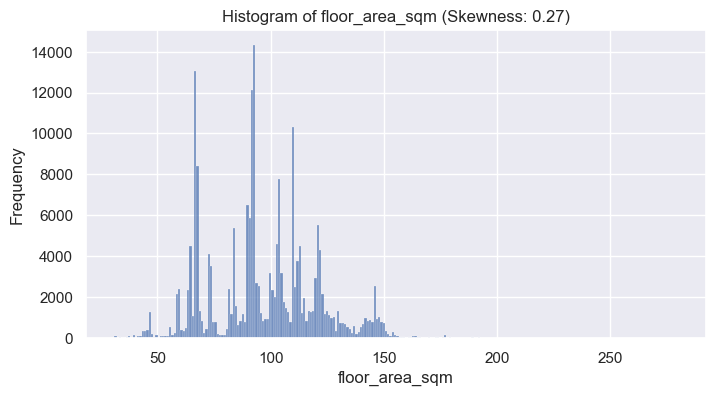

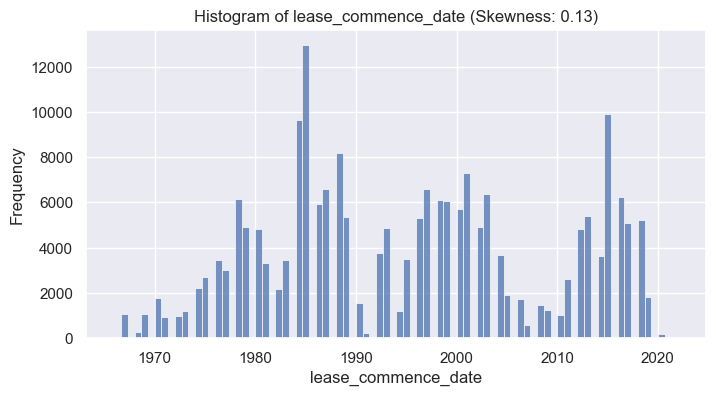

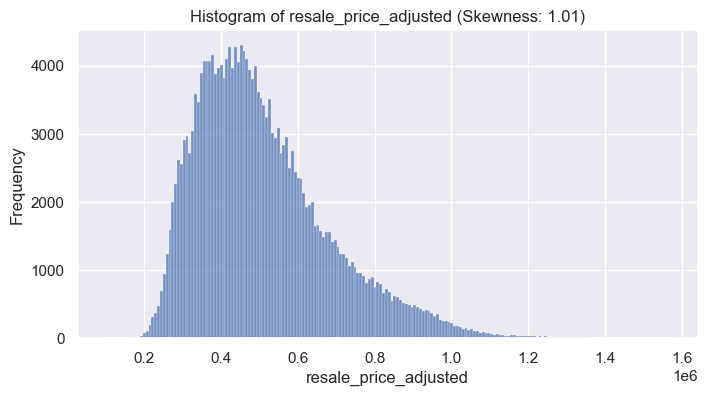

In [17]:
skewness_values = final_data[['floor_area_sqm', 'lease_commence_date','resale_price_adjusted','average_storey','town','flat_type','flat_model']].skew()

# Print the skewness value for each column
print(skewness_values)

columns = ['floor_area_sqm', 'lease_commence_date','resale_price_adjusted']

for col in columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(final_data[col], kde=False)
    plt.title(f'Histogram of {col} (Skewness: {skewness_values[col]:.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


Goodness of Fit of Model on Train Dataset:
Explained Variance (R^2): 0.5974426759046065
Mean Squared Error (MSE): 12258995583.321077

Goodness of Fit of Model on Test Dataset:
Explained Variance (R^2): 0.5968202628607608
Mean Squared Error (MSE): 12374896505.21619



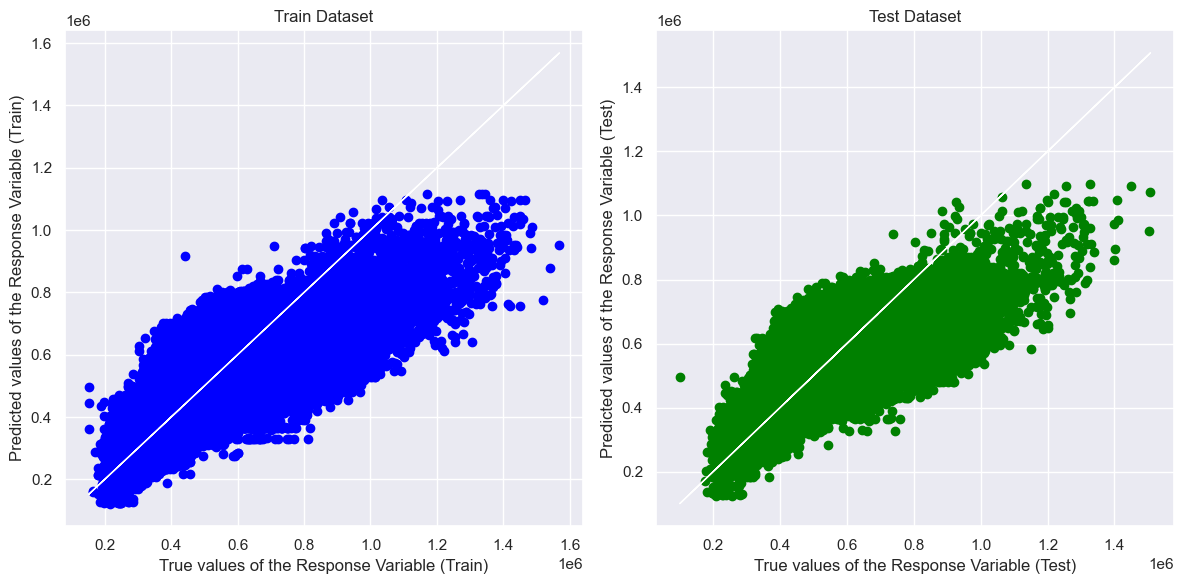

In [18]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = pd.concat([final_data[['floor_area_sqm', 'lease_commence_date', 'average_storey','town', 'flat_type', 'flat_model']]])
y = final_data['resale_price_adjusted']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Model Evaluation
print("Goodness of Fit of Model on Train Dataset:")
print("Explained Variance (R^2):", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model on Test Dataset:")
print("Explained Variance (R^2):", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions versus True values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color="blue")
plt.plot(y_train, y_train, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Train)")
plt.ylabel("Predicted values of the Response Variable (Train)")
plt.title("Train Dataset")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color="green")
plt.plot(y_test, y_test, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Test Dataset")

plt.tight_layout()
plt.show()

Goodness of Fit of Model on Train Dataset:
Explained Variance (R^2): 0.6511043670723011
Mean Squared Error (MSE): 289664099803.46716

Goodness of Fit of Model on Test Dataset:
Explained Variance (R^2): 0.6499844698384668
Mean Squared Error (MSE): 291342243561.7433



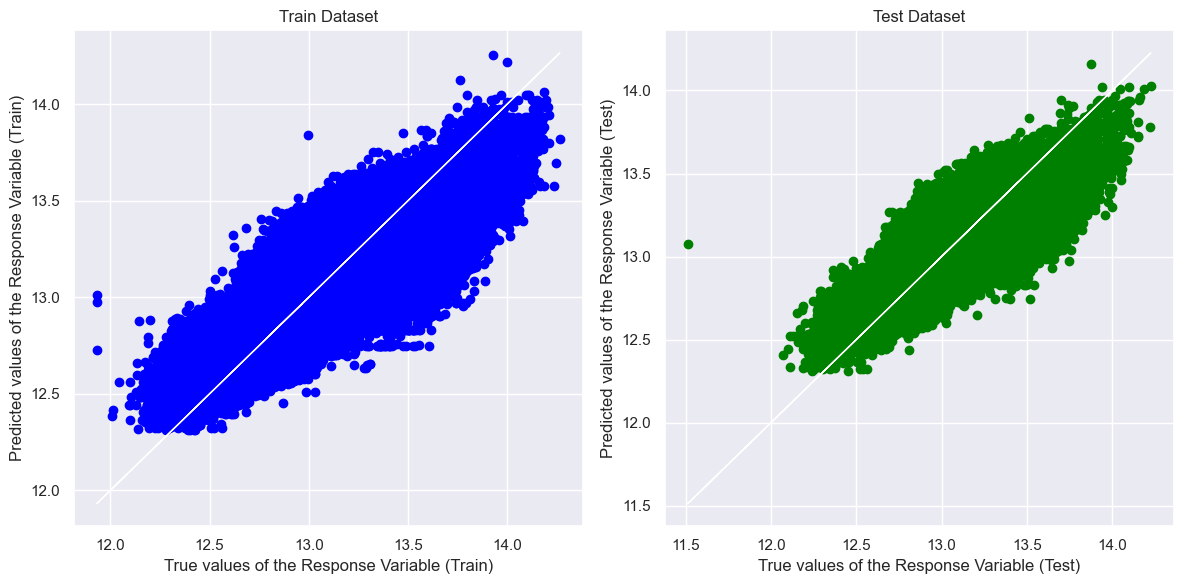

In [19]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Train a linear regression model
linreg_withLog = LinearRegression()
linreg_withLog.fit(X_train, y_train_log)

y_train_pred_log = linreg_withLog.predict(X_train)
y_test_pred_log = linreg_withLog.predict(X_test)

print("Goodness of Fit of Model on Train Dataset:")
print("Explained Variance (R^2):", linreg_withLog.score(X_train, y_train_log))
print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_train_pred_log))
print()

print("Goodness of Fit of Model on Test Dataset:")
print("Explained Variance (R^2):", linreg_withLog.score(X_test, y_test_log))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred_log))
print()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train_log, y_train_pred_log, color="blue")
plt.plot(y_train_log, y_train_log, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Train)")
plt.ylabel("Predicted values of the Response Variable (Train)")
plt.title("Train Dataset")

plt.subplot(1, 2, 2)
plt.scatter(y_test_log, y_test_pred_log, color="green")
plt.plot(y_test_log, y_test_log, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Test Dataset")

plt.tight_layout()
plt.show()

In [20]:
new_sample = {
    'floor_area_sqm': 100,
    'lease_commence_date': 2020,
    'average_storey': 10,
    'town': 'ANG MO KIO',
    'flat_type': '5 ROOM',
    'flat_model': 'Simplified'
}

new_sample_df = pd.DataFrame([new_sample])

encoded_user_input_linreg = encode_new_input(new_sample_df, encoding_mappings)

predicted_resale_value_linreg = linreg.predict(encoded_user_input_linreg)

print(f"Predicted Resale Value: {predicted_resale_value_linreg[0]}")

Predicted Resale Value: 521586.48239852395


# Load data and split

In [21]:
# Assuming 'encoded_data' is a preprocessed DataFrame where categorical columns are already encoded.
train = final_data
target = 'resale_price_adjusted'

# Randomly assign rows to train, valid, and test sets if not already done.
if 'Set' not in train.columns:
    train['Set'] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

# Get indices for each set.
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

train.head(20)


,floor_area_sqm,lease_commence_date,resale_price_adjusted,average_storey,town,flat_type,flat_model,Set
0,60.0,1986,249701.035010,8.0,0,2,6,train
1,86.0,2001,335872.372582,2.0,9,3,4,train
2,90.0,2000,332934.713346,8.0,9,3,5,train
3,90.0,2004,331955.493601,5.0,9,3,5,train
4,117.0,2012,930258.757879,20.0,23,4,6,train
5,124.0,2012,807856.289737,5.0,23,4,6,train
6,110.0,2006,805702.006298,5.0,23,4,6,train
7,111.0,2003,763791.401206,29.0,23,4,6,valid
8,115.0,2000,734414.808852,2.0,23,4,6,test
9,90.0,2008,750082.324774,32.0,23,3,5,train


In [22]:
# Define features to exclude from the model and the categorical columns
unused_feat = ['Set']
categorical_columns = ['town', 'flat_type', 'flat_model'] 

# Create a list of features to be used for training
features = ['floor_area_sqm','lease_commence_date','average_storey','town','flat_type','flat_model'] 

# Identify the index positions of categorical features in the 'features' list
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

# Compute the cardinality (number of unique values) for each categorical feature
categorical_dims = {col: train[col].nunique() for col in categorical_columns}
cat_dims = [categorical_dims[f] for f in features if f in categorical_columns]


# # Define the embedding sizes for categorical features
# cat_emb_dim = [min(50, (dim + 1) // 2) for dim in cat_dims]

print(cat_idxs)
print(cat_dims)
# print(cat_emb_dim)

[3, 4, 5]
[26, 7, 21]


In [23]:
# Initialize the TabNetRegressor with the defined categorical dimensions and embedding sizes
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_dims, cat_idxs=cat_idxs)


/Users/kur0/Documents/Year1/sc1015_lab/SC1015_Mini_Proj/.mini/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


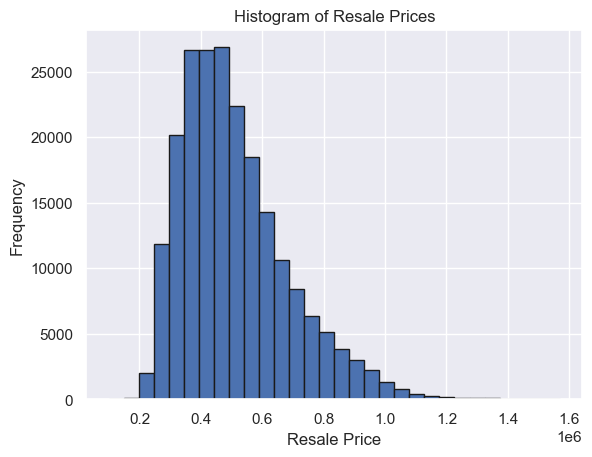

In [24]:
resale_price_adjusted = train['resale_price_adjusted']

plt.hist(resale_price_adjusted, bins=30, edgecolor='k')
plt.title('Histogram of Resale Prices')
plt.xlabel('Resale Price')
plt.ylabel('Frequency')
# hello
plt.show()

### very skewed 

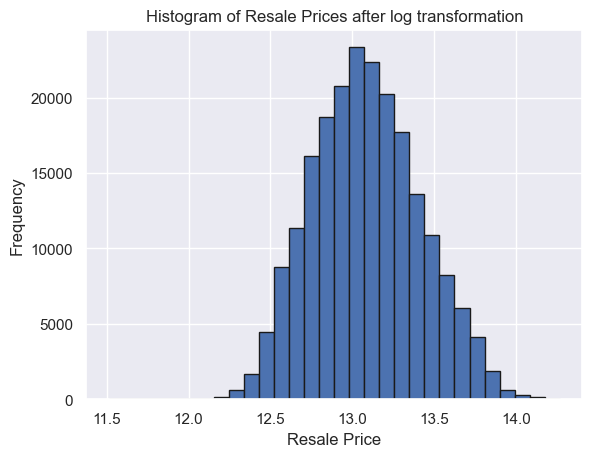

In [25]:
np.set_printoptions(suppress=True)

train['log_' + target] = np.log(train[target])

log_resale_price_adjusted = train['log_resale_price_adjusted']

plt.hist(log_resale_price_adjusted, bins=30, edgecolor='k')
plt.title('Histogram of Resale Prices after log transformation')
plt.xlabel('Resale Price')
plt.ylabel('Frequency')

plt.show()

In [26]:
X_train = train.loc[train_indices, features].values
y_train = train.loc[train_indices, target].values.reshape(-1, 1)
y_train_log = train.loc[train_indices, 'log_' + target].values.reshape(-1, 1)

X_valid = train.loc[valid_indices, features].values
y_valid = train.loc[valid_indices, target].values.reshape(-1, 1)
y_valid_log = train.loc[valid_indices, 'log_' + target].values.reshape(-1, 1)

X_test = train.loc[test_indices, features].values
y_test = train.loc[test_indices, target].values.reshape(-1, 1)
y_test_log = train.loc[test_indices, 'log_' + target].values.reshape(-1, 1)



In [27]:
print(y_test_log.size)
print(y_test.size)
print(X_test.shape)

X_test

21313
21313
(21313, 6)


array([[ 115., 2000.,    2.,   23.,    4.,    6.],
       [ 106., 1997.,    8.,   23.,    3.,    5.],
       [ 130., 2000.,   11.,    9.,    5.,    8.],
       ...,
       [  67., 1984.,    8.,   12.,    2.,    2.],
       [  84., 1985.,   11.,   12.,    3.,    3.],
       [ 105., 1990.,    2.,   12.,    3.,    5.]])

In [30]:
# Fit the TabNetRegressor on the training data
max_epochs = 200
clf.fit(
    X_train, y_train_log,
    eval_set=[(X_train, y_train_log), (X_valid, y_valid_log)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],
    max_epochs=max_epochs,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


epoch 0  | loss: 12.19458| train_rmse: 34.38452| valid_rmse: 34.41288|  0:00:07s
epoch 1  | loss: 0.03768 | train_rmse: 1.9307  | valid_rmse: 1.94754 |  0:00:16s
epoch 2  | loss: 0.02476 | train_rmse: 0.40199 | valid_rmse: 0.41354 |  0:00:24s
epoch 3  | loss: 0.02267 | train_rmse: 0.15402 | valid_rmse: 0.15374 |  0:00:32s
epoch 4  | loss: 0.02134 | train_rmse: 0.13718 | valid_rmse: 0.13653 |  0:00:39s
epoch 5  | loss: 0.02009 | train_rmse: 0.13626 | valid_rmse: 0.13538 |  0:00:47s
epoch 6  | loss: 0.02064 | train_rmse: 0.1285  | valid_rmse: 0.12743 |  0:00:55s
epoch 7  | loss: 0.01971 | train_rmse: 0.14061 | valid_rmse: 0.13996 |  0:01:03s
epoch 8  | loss: 0.01905 | train_rmse: 0.14756 | valid_rmse: 0.14627 |  0:01:11s
epoch 9  | loss: 0.02001 | train_rmse: 0.13823 | valid_rmse: 0.13765 |  0:01:19s
epoch 10 | loss: 0.02263 | train_rmse: 0.1236  | valid_rmse: 0.12272 |  0:01:27s
epoch 11 | loss: 0.01831 | train_rmse: 0.12164 | valid_rmse: 0.12035 |  0:01:35s
epoch 12 | loss: 0.01765 | t

/Users/kur0/Documents/Year1/sc1015_lab/SC1015_Mini_Proj/.mini/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


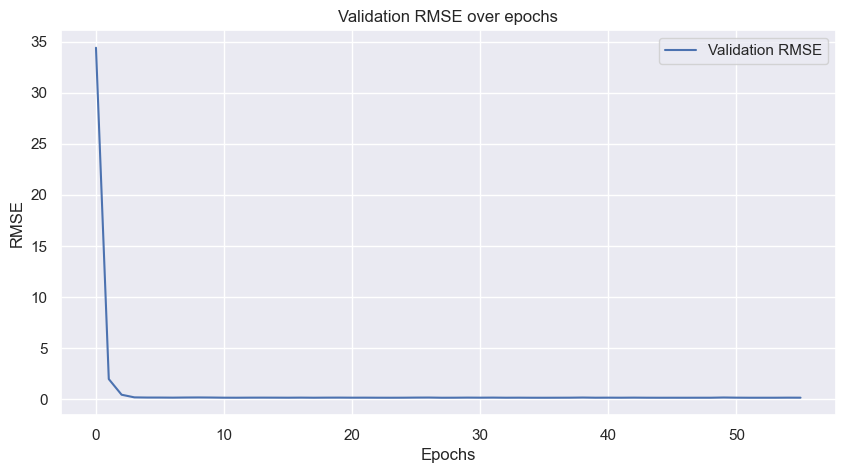

In [31]:
valid_rmse = clf.history['valid_rmse']

epochs = range(len(valid_rmse))

plt.figure(figsize=(10,5))
plt.plot(epochs, valid_rmse, label='Validation RMSE')
plt.title('Validation RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

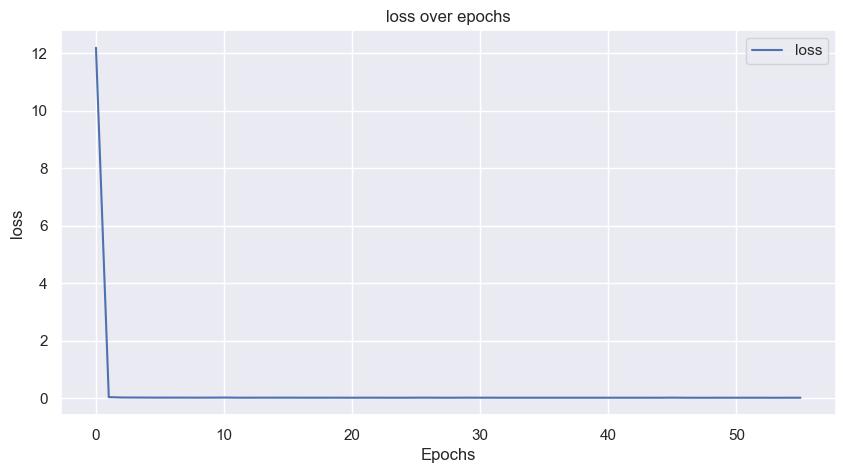

In [32]:
loss = clf.history['loss']

epochs = range(len(loss))

plt.figure(figsize=(10,5))
plt.plot(epochs, loss, label='loss')
plt.title('loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [33]:
# Predict and evaluate the model on the test set
predictions = clf.predict(X_test)

# Calculate RMSE for the test set predictions
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_log, predictions))
print(f"RMSE on test set: {rmse}")

RMSE on test set: 0.11757177131236636


In [34]:
from sklearn.metrics import r2_score

y_test_pred = np.exp(predictions)  
r2_withLog = r2_score(y_test_log, predictions)
r2 = r2_score(y_test, y_test_pred)  

print(f"R^2 on test set before transformation: {r2_withLog}")
print(f"R^2 on test set after transformation: {r2}")


R^2 on test set before transformation: 0.8721728668455879
R^2 on test set after transformation: 0.8743222250521505


In [35]:
print(encoding_mappings)

train

{'town': {'ANG MO KIO': 0, 'YISHUN': 1, 'BEDOK': 2, 'BUKIT BATOK': 3, 'GEYLANG': 4, 'WOODLANDS': 5, 'TOA PAYOH': 6, 'JURONG EAST': 7, 'JURONG WEST': 8, 'SEMBAWANG': 9, 'CHOA CHU KANG': 10, 'CLEMENTI': 11, 'HOUGANG': 12, 'BUKIT PANJANG': 13, 'SENGKANG': 14, 'MARINE PARADE': 15, 'TAMPINES': 16, 'SERANGOON': 17, 'PUNGGOL': 18, 'KALLANG/WHAMPOA': 19, 'PASIR RIS': 20, 'CENTRAL AREA': 21, 'BUKIT MERAH': 22, 'QUEENSTOWN': 23, 'BISHAN': 24, 'BUKIT TIMAH': 25}, 'flat_type': {'1 ROOM': 0, '2 ROOM': 1, '3 ROOM': 2, '4 ROOM': 3, '5 ROOM': 4, 'EXECUTIVE': 5, 'MULTI-GENERATION': 6}, 'flat_model': {'2-room': 0, 'Standard': 1, 'New Generation': 2, 'Simplified': 3, 'Model A2': 4, 'Model A': 5, 'Improved': 6, 'Premium Apartment': 7, 'Apartment': 8, '3Gen': 9, 'Improved-Maisonette': 10, 'Maisonette': 11, 'Adjoined flat': 12, 'Model A-Maisonette': 13, 'DBSS': 14, 'Premium Maisonette': 15, 'Multi Generation': 16, 'Terrace': 17, 'Type S1': 18, 'Premium Apartment Loft': 19, 'Type S2': 20}}


,floor_area_sqm,lease_commence_date,resale_price_adjusted,average_storey,town,flat_type,flat_model,Set,log_resale_price_adjusted
0,60.0,1986,249701.035010,8.0,0,2,6,train,12.428020
1,86.0,2001,335872.372582,2.0,9,3,4,train,12.724487
2,90.0,2000,332934.713346,8.0,9,3,5,train,12.715702
3,90.0,2004,331955.493601,5.0,9,3,5,train,12.712756
4,117.0,2012,930258.757879,20.0,23,4,6,train,13.743218
...,...,...,...,...,...,...,...,...,...
212143,105.0,1990,538888.000000,2.0,12,3,5,test,13.197263
212144,91.0,1985,538000.000000,11.0,12,3,2,valid,13.195614
212145,98.0,1978,538000.000000,8.0,12,3,2,train,13.195614
212146,92.0,2019,573000.000000,5.0,12,3,5,train,13.258641


In [58]:
new_sample = {
    'floor_area_sqm': 143,
    'lease_commence_date': 2021,
    'average_storey': 10,
    'town': 'JURONG WEST',
    'flat_type': '5 ROOM',
    'flat_model': 'Apartment'
}

new_sample_df = pd.DataFrame([new_sample])

encoded_user_input1 = encode_new_input(new_sample, encoding_mappings)
encoded_user_input2 = encode_new_input(new_sample_df, encoding_mappings)
encoded_user_input_array = encoded_user_input1.to_numpy()

#annoying coz clf.predict take in array but linreg.predict take in df
predicted_resale_price_clf = np.exp(clf.predict(encoded_user_input_array))
predicted_resale_price_linreg = linreg.predict(encoded_user_input2)
predicted_resale_price_linreg_withLog = np.exp(linreg_withLog.predict(encoded_user_input2))

print(f"Predicted Resale Value for clf:                         {predicted_resale_price_clf[0]}")
print(f"Predicted Resale Value for linreg:                      {predicted_resale_price_linreg[0]}")
print(f"Predicted Resale Value for linreg with transformation:  {predicted_resale_price_linreg_withLog[0]}")

Predicted Resale Value for clf:                         [781666.44]
Predicted Resale Value for linreg:                      731076.8776443554
Predicted Resale Value for linreg with transformation:  773891.7261294534
